
# COE005 - HOMEWORK 2 (NEURAL STYLE TRANSFER)

Step 1. Import the libraries needed for NST

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [4]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [5]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Step 2. Import the images to be used

In [6]:
content = 'TIP_TechnoCore.jpg'
style1 = 'Ukiyo-e_Style.jpg'

Set the dimensions of the image to 512

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Display images of the original image and the style image

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

# 1st Style - Ukiyo-e

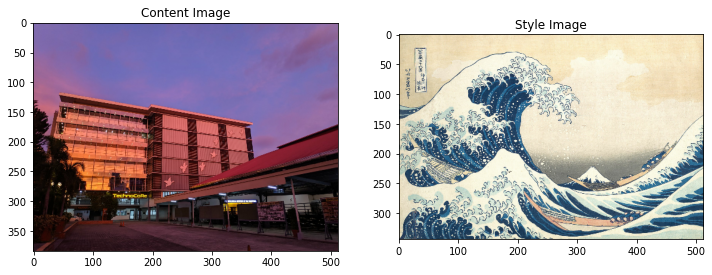

In [18]:
content_image = load_img(content)
style_image_1 = load_img(style1)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image_1, 'Style Image')

Using TF-hub, a fast style transfer of the content image can be made.

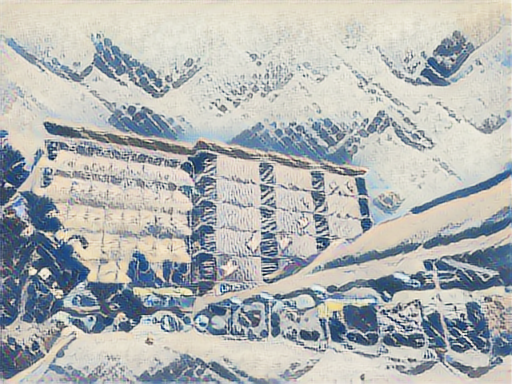

In [19]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image_1))[0]
tensor_to_image(stylized_image)

Define the model to be used. In this one, VGG19 will be used.

In [20]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [21]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('cinema', 0.29461548),
 ('library', 0.04050183),
 ('fire_engine', 0.039418697),
 ('planetarium', 0.03768365),
 ('freight_car', 0.03280036)]

Show the layers that can be possibly used

In [22]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Select the style layers for the Ukiyo-e style painting.

In [27]:
content_layers = ['block5_conv4'] 

style_layers_1 = ['block1_conv1',
                'block2_conv2',
                'block3_conv3', 
                'block4_conv4', 
                'block5_conv4']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers_1)

Create model

In [28]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [29]:
style_extractor = vgg_layers(style_layers_1)
style_outputs_1 = style_extractor(style_image_1*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers_1, style_outputs_1):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 344, 512, 64)
  min:  0.0
  max:  827.922
  mean:  37.736057

block2_conv2
  shape:  (1, 172, 256, 128)
  min:  0.0
  max:  6855.9336
  mean:  198.92072

block3_conv3
  shape:  (1, 86, 128, 256)
  min:  0.0
  max:  8773.462
  mean:  527.5477

block4_conv4
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  7374.769
  mean:  52.64414

block5_conv4
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  212.26912
  mean:  1.2772448



Calculate the chosen style.

In [30]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Extract the Ukiyo-e Style and the TIP TechnoCore image.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers_1, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers_1 + content_layers)
    self.style_layers_1 = style_layers_1
    self.content_layers = content_layers
    self.num_style_layers_1 = len(style_layers_1)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs_1, content_outputs = (outputs[:self.num_style_layers_1],
                                      outputs[self.num_style_layers_1:])

    style_outputs_1 = [gram_matrix(style_output)
                     for style_output in style_outputs_1]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers_1, style_outputs_1)}

    return {'content': content_dict, 'style_1': style_dict}

In [41]:
extractor = StyleContentModel(style_layers_1, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style_1'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0043622456
    max:  18652.803
    mean:  720.94574

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.10063007
    max:  289140.9
    mean:  15081.095

   block3_conv3
    shape:  (1, 256, 256)
    min:  1884.2374
    max:  1421697.9
    mean:  125352.05

   block4_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  171586.17
    mean:  1847.2015

   block5_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  860.8994
    mean:  0.66881514

Contents:
   block5_conv4
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  135.26706
    mean:  0.6293256


In [42]:
style_targets_1 = extractor(style_image_1)['style_1']
content_targets = extractor(content_image)['content']

In [43]:
image = tf.Variable(content_image)

In [44]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [46]:
style_weight=1e-2
content_weight=1e4

In [56]:
def style_content_loss(outputs):
    style_outputs_1 = outputs['style_1']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs_1[name]-style_targets_1[name])**2) 
                           for name in style_outputs_1.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [57]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

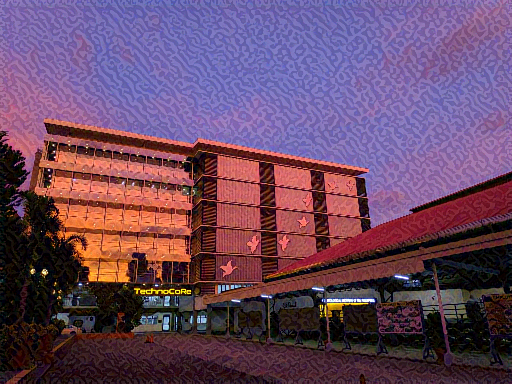

In [58]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Perform optimization

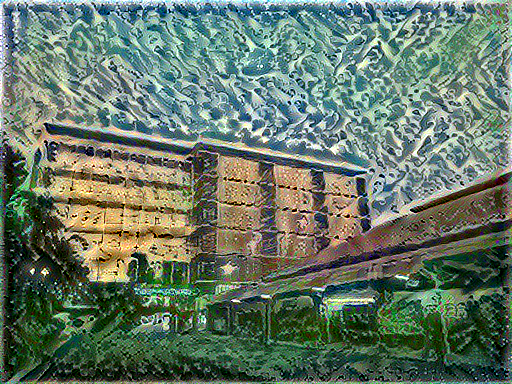

Train step: 100
Total time: 2946.8


In [59]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Total variation loss is then used to decrease the produced frequency.

In [61]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

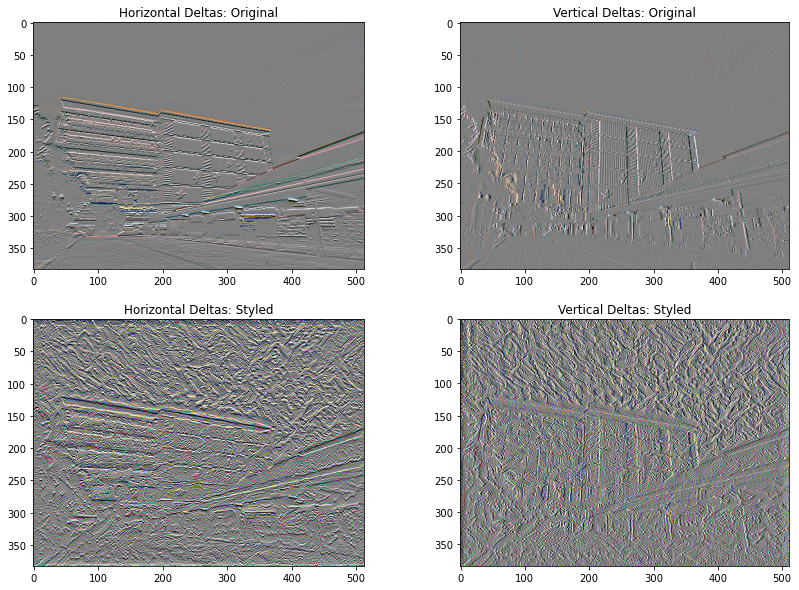

In [62]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [63]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [64]:
total_variation_loss(image).numpy()

151204.47

In [65]:
tf.image.total_variation(image).numpy()

array([151204.47], dtype=float32)

In [66]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Rerun the optimization

In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

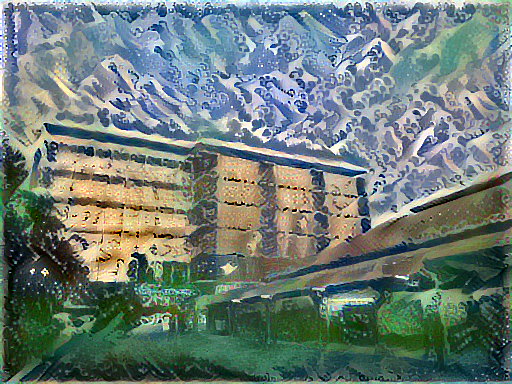

Train step: 200
Total time: 6050.6


In [68]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 20

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Final result

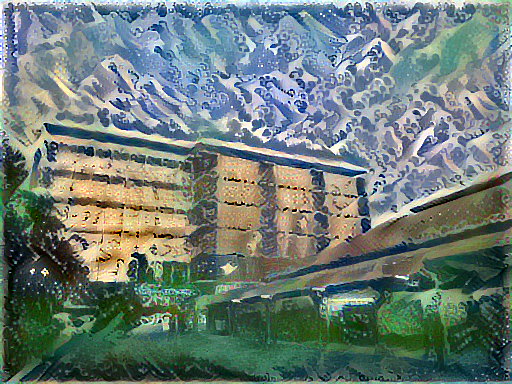

In [69]:
tensor_to_image(image)

Save the image

In [84]:
file_name = 'TIP_Ukiyo_Style.jpg'
tensor_to_image(image).save(file_name)